In [3]:
# make sure TF is below 2.16!
# Otherwise the model won't be able to load.
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


In [4]:
# GPU info:
!nvidia-smi

Mon Dec  2 15:23:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:88:00.0 Off |                  N/A |
| 30%   25C    P8              19W / 250W |      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Assign GPU to use:
GPU_id = '7'
import os
os.environ["CUDA_VISIBLE_DEVICES"]=GPU_id
# check:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# check:
sess = tf.compat.v1.Session()
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("GPU working")
else:
    print("GPU not working")

GPU working


2024-12-02 15:29:57.642846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:de:00.0, compute capability: 7.5


In [7]:
# check:
for device in gpu_devices:
    print("device name:", device.name)
    print("device type:", device.device_type)

device name: /physical_device:GPU:0
device type: GPU


In [ ]:
import pandas as pd
L5_8mer_df = pd.read_table('/content/L5_2-8mer.tsv')
L5_8mer_df

In [9]:
pip install logomaker

Note: you may need to restart the kernel to use updated packages.


In [10]:
# 8-mer mutagenesis:

# Function to generate a list of all possible mutations for a seq:
def all_possible_mutations(dna_seq):
    mutated_seqs = []
    for i in range(len(dna_seq)):
        for nucleotide in ["A", "T", "C", "G"]:
            if nucleotide != dna_seq[i]:
                mutated_seq = dna_seq[:i] + nucleotide + dna_seq[i+1:]
                mutated_seqs.append(mutated_seq)
    #
    return mutated_seqs


# functions to get a df of the regulatory relevance of each nucleotide of 8-mer:
import pandas as pd
import numpy as np
def kmer_saliency_df(kmer = 'GGTAAGTA', target = 'delta.log2expression'):
    # generate all point mutations:
    all_mutants = all_possible_mutations(kmer)
    # add the original seq to the mutant list:
    all_mutants.insert(0, kmer)
    # create empty df:
    kmer_values = pd.DataFrame(columns=['kmer', 'value'])
    # find values by each k-mer:
    for the_kmer in all_mutants:
        match = L5_8mer_df.loc[L5_8mer_df['kmer'] == the_kmer, target]
        new_row = pd.DataFrame({'kmer': [the_kmer], 'value': [match.values[0]]})
        kmer_values = pd.concat([kmer_values, new_row], ignore_index=True)
    # calculate delta:
    values = kmer_values['value'].values
    deltas = values[0] - values[1:]
    # median deltas of each original nucleotide/position:
    delta_medians = []
    for i in range(3, len(deltas)+1, 3):
        median = np.median(deltas[i-3:i])
        delta_medians.append(median)
    # form the final data.frame suitable for logomaker:
    position_list = list(kmer)
    final_df = pd.DataFrame(columns=['A', 'C', 'G', 'T'])
    for i, letter in enumerate(position_list):
        final_df.at[i, letter] = delta_medians[i]
    final_df = final_df.fillna(0)
    final_df = final_df.astype('float64')
    # change row index to 1,2,3...:
    final_df.index = range(1, len(final_df) + 1)
    #
    return final_df


# function to plot nucleotide saliencies:
import logomaker
import matplotlib.pyplot as plt
def plot_saliency(df, negative=False,
                  start=None, end=None, figsize=[8,2],
                  xticks=False, yticks=False,
                  spines=False, ylim=None):
    # make Figure and Axes objects:
    fig, ax = plt.subplots(1,1,figsize=figsize)
    # limit x range, if defined:
    if start is not None and end is not None:
        df = df[start : end+1]
    elif start is not None:
        df = df[start : ]
    elif end is not None:
        df = df[ : end+1]
    # flip saliencies if defined:
    if negative == True:
        df = -df
    #
    logo = logomaker.Logo(df, ax=ax)
    #
    if ylim is not None:
        logo.ax.set_ylim(ylim)
    #
    if spines==False:
        logo.style_spines(visible=False)
    #
    if xticks==False:
        ax.set_xticks([])
    #
    if yticks==False:
        ax.set_yticks([])
    #
    return logo.fig.tight_layout()

In [ ]:
# k-mer motif:
kmer = 'AGGTAAGT'
target = 'delta.log2expression' # delta.log2expression / delta.log2export

the_kmer_saliency_df = kmer_saliency_df(kmer=kmer, target=target)
the_kmer_saliency_df

In [ ]:
plot_saliency(df=the_kmer_saliency_df, negative=True, figsize=[3,2])

In [11]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [12]:
# k-mer context dependencies:


# Define the model:
model = '/rd4/users/liangn/L5-220528_em5-LSTM64x32x0.5-64x0.5-rep4.hdf5'
model_x_length = 46
optimal_x_length = 45


# Function to convert a DNA sequence to vector:
vocab = ['pad','N','A','T','C','G']
char2idx = {u:i for i, u in enumerate(vocab)}
def vectorize_dna_seq(dna_seq):
    vectorized_dna_seq = [char2idx[char] for char in dna_seq]
    return vectorized_dna_seq


# Function to convert a list of DNA into x array for ANN inputs:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def prepare_x(dna_list, x_lenth):
    x = list(map(vectorize_dna_seq, dna_list))
    x = pad_sequences(x, maxlen=x_lenth, padding='post')
    #
    return x


# function to split a string into k-mers:
def kmerize(string, k):
    return [string[i:i+k] for i in range(len(string)-k+1)]


# function to predict big seq with sliding windows:
import pandas as pd
from keras.models import load_model
import numpy as np
def predict_big(big_seqs, k=optimal_x_length, model_x_length=model_x_length, model=model):
    # form data.frame:
    # if big_seqs only had one, convert to a list as well:
    if isinstance(big_seqs, str):
        big_seqs = [big_seqs]
    seq_df = pd.DataFrame({'seq': big_seqs})
    # split each seq into k-mers, mark indexes:
    seq_df = seq_df['seq'].apply(lambda x: kmerize(x, k))
    seq_df = seq_df.apply(pd.Series)
    seq_df = seq_df.stack().reset_index(level=1, drop=True).to_frame('seq')
    # prepare x for predictions:
    x = seq_df['seq'].apply(vectorize_dna_seq)
    x = pad_sequences(x, maxlen=model_x_length, padding='post')
    # predict:
    Model = load_model(model)
    y_pred = Model.predict(x)
    # take group means of the same indexes:
    unique_index = np.unique(seq_df.index)
    y_pred_mean = np.zeros((len(unique_index), y_pred.shape[1]))
    for i in range(len(unique_index)):
        y_pred_mean[i] = np.mean(y_pred[seq_df.index == unique_index[i]], axis=0)
    #
    return y_pred_mean


# function to get a df of the regulatory relevance of each nucleotide of a seq:
from keras.models import load_model
import pandas as pd
def saliency_df(seq, optimal_x_length=optimal_x_length, model_x_length=model_x_length, model=model,
                target='expression'):
    # generate all point mutations:
    all_mutants = all_possible_mutations(seq)
    # add the original seq to the mutant list:
    all_mutants.insert(0, seq)
    # check seq length:
    seq_len = len(seq)
    # predict the mutants:
    # use different prediction strategy by seq length:
    if seq_len == optimal_x_length:
        x = prepare_x(all_mutants, model_x_length)
        Model = load_model(model)
        y_pred = Model.predict(x)
    else:
        y_pred = predict_big(big_seqs=all_mutants, k=optimal_x_length, model_x_length=model_x_length,
                             model=model)
    # convert array to dataframe:
    pred_df = pd.DataFrame(y_pred, columns = ['nuc','cyt'])
    # calculate values:
    pred_df['nuc'] = 2**pred_df['nuc']
    pred_df['cyt'] = 2**pred_df['cyt']
    pred_df['expression'] = pred_df['cyt']*(16/17) + pred_df['nuc']*(1/17)
    pred_df['export'] = pred_df['cyt']/pred_df['nuc']
    # calculate delta:
    values = pred_df[target].values
    deltas = values[0] - values[1:]
    # median deltas of each original nucleotide/position:
    delta_medians = []
    for i in range(3, len(deltas)+1, 3):
      median = np.median(deltas[i-3:i])
      delta_medians.append(median)
    # form the final data.frame suitable for logomaker:
    seq_list = list(seq)
    df = pd.DataFrame(columns=['A', 'C', 'G', 'T'])
    for i, letter in enumerate(seq_list):
      df.at[i, letter] = delta_medians[i]
    df = df.fillna(0)
    df = df.astype('float64')
    # change row index to 1,2,3...:
    df.index = range(1, len(df) + 1)
    #
    return df


# Function that performs one evolutionary step on the context of a k-mer:
def evolve_target_saliency_once(seq, left_i=19, right_i=26, target='expression',
                                 negative=True, decreasing=False):
    # generate all mutants:
    all_mutants = all_possible_mutations(seq)
    # remove mutations on the k-mer:
    del all_mutants[(left_i-1)*3 : right_i*3]
    # add the original seq to the mutant list:
    all_mutants.insert(0, seq)
    # calculate target saliency of each mutant:
    mut_saliencies = pd.DataFrame(columns=['seq', 'saliency'])
    for the_seq in all_mutants:
        the_N45_saliency_df = saliency_df(the_seq, target=target)
        the_targeted_saliency = the_N45_saliency_df.loc[left_i:right_i].sum().sum()
        if negative == True:
            the_targeted_saliency = -the_targeted_saliency
        new_data = pd.DataFrame({'seq': [the_seq], 'saliency': [the_targeted_saliency]})
        mut_saliencies = pd.concat([mut_saliencies, new_data], ignore_index=True)
    # only report improved ones:
    if decreasing==True:
        mut_saliencies = mut_saliencies.loc[mut_saliencies['saliency']<mut_saliencies['saliency'][0]]
    else:
        mut_saliencies = mut_saliencies.loc[mut_saliencies['saliency']>mut_saliencies['saliency'][0]]
    # sort df by target:
    mut_saliencies = mut_saliencies.sort_values(by='saliency', ascending=decreasing)
    #
    return mut_saliencies


# Function that evolves the context of a k-mer to the extreme:
def extreme_target_saliency_evolve(seq, left_i=19, right_i=26, target='expression',
                                   negative=True, decreasing=False):
    # initiate the evolution:
    df = evolve_target_saliency_once(seq=seq, left_i=left_i, right_i=right_i, target=target,
                                     negative=negative, decreasing=decreasing)
    # continue evolution if possible:
    if len(df.index)>0:
        new_seq = df.iloc[0]['seq']
        new_df = df
        while len(new_df.index)>0:
            new_df = evolve_target_saliency_once(seq=new_seq, left_i=left_i, right_i=right_i, target=target,
                                     negative=negative, decreasing=decreasing)
            if len(new_df.index)>0:
                new_seq = new_df.iloc[0]['seq']
                df = new_df
    return df


# function to calculate the connections between nucleotides:
import numpy as np
import matplotlib.pylab as plt
def connections_array (seq, target='expression', optimal_x_length=optimal_x_length,
                     model_x_length=model_x_length, model=model):
    # generate all point mutations:
    all_mutants = all_possible_mutations(seq)
    # add the original seq to the mutant list:
    all_mutants.insert(0, seq)
    # generate a list of saliency data.frames for each mutant:
    df_list = [saliency_df(seq=seq, optimal_x_length=optimal_x_length, model_x_length=model_x_length,
                       model=model, target=target) for seq in all_mutants]
    # convert the data.frames into arrays by summing ATCG values:
    all_saliencies = np.vstack([df.sum(axis=1) for df in df_list])
    # calculate fold changes:
    all_saliencies_fc = np.divide(all_saliencies[1:], all_saliencies[0])
    # group the mutants by the position of mutations:
    sub_arrays = np.array_split(all_saliencies_fc, len(all_saliencies_fc)/3)
    # take medians:
    medians_array = np.array([np.median(sub_array, axis=0) for sub_array in sub_arrays])
    #
    return medians_array


# function to plot the connections:
import seaborn as sns
def plot_connections (array, size):
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(array, linewidth=0, center=1, cbar_kws={"shrink": .5}, vmin=0, vmax=2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.ylabel('Mutated position', fontsize = 15, weight='bold')
    plt.xlabel('Affected position', fontsize = 15, weight='bold')
    #
    ax.set_xticks(np.linspace(1.5, array.shape[1]-1.5, num=int(array.shape[1]/2)))
    ax.set_yticks(np.linspace(1.5, array.shape[0]-1.5, num=int(array.shape[0]/2)))
    #
    ax.set_xticklabels([num for num in range(2, array.shape[1]+1, 2)])
    ax.set_yticklabels([num for num in range(2, array.shape[0]+1, 2)])
    plt.show()


In [ ]:
# k-mer context evolve:
the_extreme_context_df = extreme_target_saliency_evolve(
    seq='TTTTTTTTTTTTTTTTTTCTCCTCAATTTTTTTTTTTTTTTTTTT', # TTTTTTTTTTTTTTTTTTAAAAAAAATTTTTTTTTTTTTTTTTTT
    left_i=19, right_i=26, target='export', negative=False, decreasing=True)
the_extreme_context_df

In [ ]:
the_extreme_context_df

In [ ]:
N45 = 'CACGCTCGTAATACGGTGAAAAAAAAAAACCCCTTCTCCCTTCCC'
the_N45_saliency_df = saliency_df(seq=N45, target='expression')
the_N45_saliency_df

In [ ]:
plot_saliency(df=the_N45_saliency_df, negative=True, figsize=[8,2], xticks=True, yticks=True)

In [ ]:
plot_saliency(df=the_N45_saliency_df, negative=False, figsize=[8,2], xticks=True, yticks=True,
             ylim=[-0.04, 0.09])

In [ ]:
con_arr = connections_array (seq=N45, target='export')
con_arr

In [ ]:
plot_connections(array=con_arr, size=9)

In [ ]:
# quantify k-mer context effects:

# function to generate random sequences containing a fixed k-mer in certain position:
import random
def kmer_random_contexts(num_seq=8, seq_len=45, fixed_kmer="TTTTTTTT", fixed_kmer_start=19):
    sequences = []
    for _ in range(num_seq):
        random_seq = ''.join(random.choice('ATCG') for _ in range(seq_len))
        sequence = random_seq[:(fixed_kmer_start-1)] + fixed_kmer + random_seq[(fixed_kmer_start-1) + len(fixed_kmer):]
        sequences.append(sequence)
    return sequences

kmer = 'TATGTTTT'
phenotype = 'export'
seq_len = 45
kmer_position = 19
num_seq = 256

seqs = kmer_random_contexts(num_seq=num_seq, seq_len=seq_len, fixed_kmer=kmer, fixed_kmer_start=kmer_position)
seqs

In [ ]:
# negative control:
kmer = 'Random'
phenotype = 'export'
seq_len = 45
kmer_position = 19
num_seq = 256

# generate pure random seqs:
import random
def generate_random_sequence(length):
    sequence = ''
    nucleotides = ['A', 'T', 'C', 'G']
    for _ in range(length):
        sequence += random.choice(nucleotides)
    return sequence

seqs = []
for _ in range(num_seq):
    sequence = generate_random_sequence(seq_len)
    seqs.append(sequence)

seqs

In [ ]:
# calculate k-mer position index:
left_i = kmer_position
right_i = left_i+len(kmer)-1

In [ ]:
# for NC:
kmer_len = 8
left_i = kmer_position
right_i = left_i+kmer_len-1

In [ ]:
# create a new df:
kmer_saliencies = pd.DataFrame(columns=['kmer', 'position', 'seq', 'phenotype', 'saliency'])
# run saliency tests:
for the_seq in seqs:
    # generate saliency df:
    the_seq_saliency_df = saliency_df(the_seq, target=phenotype)
    # calculate k-mer saliency:
    the_targeted_saliency = the_seq_saliency_df.loc[left_i:right_i].sum().sum()
    new_data = pd.DataFrame({'kmer': [kmer],
                             'position': [kmer_position],
                             'seq': [the_seq],
                             'phenotype': [phenotype],
                             'saliency': [the_targeted_saliency]})
    kmer_saliencies = pd.concat([kmer_saliencies, new_data], ignore_index=True)
kmer_saliencies

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=kmer_saliencies, x="saliency", y="kmer", width=.5)
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

In [ ]:
# add new results to the df:
all_kmer_saliencies = all_kmer_saliencies.append(kmer_saliencies, ignore_index=True)
all_kmer_saliencies

In [ ]:
# saliency medians:
group_medians = all_kmer_saliencies.groupby('kmer')['saliency'].median()
group_medians

In [ ]:
# normalize saliencies:
all_kmer_saliencies['norm_saliency'] = all_kmer_saliencies.apply(
    lambda row: row['saliency'] / group_medians[row['kmer']], axis=1
)
all_kmer_saliencies

In [ ]:
all_kmer_saliencies[all_kmer_saliencies['kmer'] == 'TATTTATT']

In [ ]:
# draw boxplot as final result:
import seaborn as sns
import matplotlib.pyplot as plt
kmer_order = [
    'AGGTAAGT', 'TTTTTTTT', 'AAAAAAAA', 'GGGGGGGG', 'TATGTTTT',
    'TCGTCCCG', 'CTCCTCAA', 'ACGCCAGT', 'AACCACGT',
    'TGAAGAAA', 'ACCCAGAA',
    'TATTTATT', 'Random'
]
fig = plt.figure(figsize=(6, 6))
sns.boxplot(data=all_kmer_saliencies, x="norm_saliency", y="kmer", order=kmer_order, width=.5)
ax = plt.gca()
ax.set_xlabel('Fold changes in regulatory correlation', fontsize=13)
ax.set_ylabel('Regulatory k-mers', fontsize=13)
plt.xlim(-2, 4)
plt.axvline(x=1, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

In [ ]:
# save:
all_kmer_saliencies.to_csv('kmer_random_context_saliencies.csv', index=False)

In [13]:
# Function that performs one evolutionary step on the context of a k-mer:
def evolve_target_saliency_once(seq, left_i=19, right_i=26, target='expression',
                                 negative=True, decreasing=False):
    # generate all mutants:
    all_mutants = all_possible_mutations(seq)
    # remove mutations on the k-mer:
    del all_mutants[(left_i-1)*3 : right_i*3]
    # add the original seq to the mutant list:
    all_mutants.insert(0, seq)
    # calculate target saliency of each mutant:
    mut_saliencies = pd.DataFrame(columns=['seq', 'saliency'])
    for the_seq in all_mutants:
        the_N45_saliency_df = saliency_df(the_seq, target=target)
        the_targeted_saliency = the_N45_saliency_df.loc[left_i:right_i].sum().sum()
        if negative == True:
            the_targeted_saliency = -the_targeted_saliency
        mut_saliencies = mut_saliencies.append({'seq': the_seq, 'saliency': the_targeted_saliency},
                                               ignore_index=True)
    # only report improved ones:
    if decreasing==True:
        mut_saliencies = mut_saliencies.loc[mut_saliencies['saliency']<mut_saliencies['saliency'][0]]
    else:
        mut_saliencies = mut_saliencies.loc[mut_saliencies['saliency']>mut_saliencies['saliency'][0]]
    # sort df by target:
    mut_saliencies = mut_saliencies.sort_values(by='saliency', ascending=decreasing)
    #
    return mut_saliencies

In [15]:
# function to make a single-step evolution:
def evolve_once (seq, target='expression', decreasing=False, exclude=['QWERT']):
    # generate all mutants:
    all_mutants = all_possible_mutations(seq)
    # add the original seq to the mutant list:
    all_mutants.insert(0, seq)
    # check seq length:
    seq_len = len(seq)
    # predict the mutants:
    # use different prediction strategy by seq length:
    if seq_len == optimal_x_length:
        x = prepare_x(all_mutants, model_x_length)
        Model = load_model(model)
        y_pred = Model.predict(x)
    else:
        y_pred = predict_big(big_seqs=all_mutants, k=optimal_x_length)
    # convert array to dataframe:
    pred_df = pd.DataFrame(y_pred, columns = ['nuc','cyt'])
    # calculate values:
    pred_df['nuc'] = 2**pred_df['nuc']
    pred_df['cyt'] = 2**pred_df['cyt']
    pred_df['expression'] = pred_df['cyt']*(16/17) + pred_df['nuc']*(1/17)
    pred_df['export'] = pred_df['cyt']/pred_df['nuc']
    # add seq to df:
    pred_df['seq'] = all_mutants
    # only report improved ones:
    if decreasing==True:
        pred_df = pred_df.loc[pred_df[target]<pred_df[target][0]]
    else:
        pred_df = pred_df.loc[pred_df[target]>pred_df[target][0]]
    # exclude certain motifs:
    rows_to_remove = pred_df[pred_df['seq'].str.contains('|'.join(exclude))]
    pred_df = pred_df[~pred_df['seq'].isin(rows_to_remove['seq'])]
    # sort df by target:
    pred_df = pred_df.sort_values(by=target, ascending=decreasing)
    #
    return pred_df


# Function to make extreme evolutions:
def extreme_evolve(seq, target='expression', decreasing=False, exclude=['QWERT']):
    # initiate the evolution:
    df = evolve_once(seq, target=target, decreasing=decreasing, exclude=exclude)
    # continue evolution if possible:
    if len(df.index)>0:
        new_seq = df.iloc[0]['seq']
        new_df = df
        while len(new_df.index)>0:
            new_df = evolve_once(new_seq, target=target, decreasing=decreasing, exclude=exclude)
            if len(new_df.index)>0:
                new_seq = new_df.iloc[0]['seq']
                df = new_df
    return df


In [ ]:
# generate random sequences without certain elements:
num_sequences = int(1e4)
sequence_length = 360
elements_to_replace = ['GT', 'GGGG', 'AAAA', 'TTTT']

# function to generate a random seq:
import random
def generate_random_sequence(length):
    bases = ['A', 'C', 'G', 'T']
    return ''.join(random.choices(bases, k=length))

# function to replace all elements in a seq to random:
import re
import random
def replace_elements(sequence, elements):
    pattern = r'|'.join([re.escape(e) for e in elements])
    while True:
        matches = re.findall(pattern, sequence)
        if not matches:
            break
        for match in matches:
            replacement = ''.join(random.choice('ACGT') for _ in range(len(match)))
            sequence = sequence.replace(match, replacement, 1)
    return sequence

# perform generation:
sequences = []
for _ in range(num_sequences):
    sequence = generate_random_sequence(sequence_length)
    sequence = replace_elements(sequence, elements_to_replace)
    sequences.append(sequence)

sequences

In [ ]:
# or:
sequences = ['CATTCTCCACTTCTTGTTCCCCACTGACAGCCTCCCACCCCCATCTCTCCCTCCCCTGCCATTTTGGGTTTTGGGTCTTTGAACCCTTGCTTGCAATAGGTGTGCGTCAGAAGCACCCAGGACTTCCATTTGCTTTGTCCCGGGGCTCCACTGAACAAGTTGGCCTGCACTGGTGTTTTGTTGTGGGGAGGAGGATGGGGAGTAGGACATACCAGCTTAGATTTTAAGGTTTTTACTGTGAGGGATGTTTGGGAGATGTAAGAAATGTTCTTGCAGTTAAGGGTTAGTTTACAATCAGCCACATTCTAGGTAGGGGCCCACTTCACCGTACTAACCAGGGAAGCTGTCCCTCACTGTTGAATTTTCTCTAACTTCAAGGCCCATATCTGTGAAATGCTGGCATTTGCACCTACCTCACAGAGTGCATTGTGAGGGTTAATGAAATAATGTACATCTGGCCTTGAAACCACCTTTTATTACATGGGGTCTAGAACTTGACCCCCTTGAGGGTGCTTGTTCCCTCTCCCTGTTGGTCGGTGGGTTGGTAGTTTCTACAGTTGGGCAGCTGGTTAGGTAGAGGGAGTTGTCAAGTCTCTGCTGGCCCAGCCAAACCCTGTCTGACAACCTCTTGGTGAACCTTAGTACCTAAAAGGAAATCTCACCCCATCCCACACCCTGGAGGATTTCATCTCTTGTATATGATGATCTGGATCCACCAAGACTTGTTTTATGCTCAGGGTCAATTTCTTTTTTCTTTTTTTTTTTTTTTTTTCTTTTTCTTTGAGACTGGGTCTCGCTTTGTTGCCCAGGCTGGAGTGGAGTGGCGTGATCTTGGCTTACTGCAGCCTTTGCCTCCCCGGCTCGAGCAGTCCTGCCTCAGCCTCCGGAGTAGCTGGGACCACAGGTTCATGCCACCATGGCCAGCCAACTTTTGCATGTTTTGTAGAGATGGGGTCTCACAGTGTTGCCCAGGCTGGTCTCAAACTCCTGGGCTCAGGCGATCCACCTGTCTCAGCCTCCCAGAGTGCTGGGATTACAATTGTGAGCCACCACGTCCAGCTGGAAGGGTCAACATCTTTTACATTCTGCAAGCACATCTGCATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCA']

In [ ]:
# check elements:
elements_to_check = elements_to_replace
#
def check_sequences(dna_sequences, elements):
    containing_sequences = []
    for index, sequence in enumerate(dna_sequences):
        for element in elements:
            if element in sequence:
                containing_sequences.append(index)
                break
    return containing_sequences
#
check_sequences(sequences, elements_to_check)

In [16]:
# define model .hdf5 file:
model = '/content/L5-220528_em5-LSTM64x32x0.5-64x0.5-rep4.hdf5'
# em5>LSTM64x32*0.5>64*0.5-rep4
# CNN8*512>GAP>128
# CNN8*256>GAP

In [ ]:
# apply prediction:
y_pred = predict_big(sequences)

In [ ]:
y_pred

In [ ]:
# convert result:
pred_df = pd.DataFrame(y_pred, columns = ['nuc','cyt'])
# calculate values:
pred_df['nuc'] = 2**pred_df['nuc']
pred_df['cyt'] = 2**pred_df['cyt']
pred_df['expression'] = pred_df['cyt']*(16/17) + pred_df['nuc']*(1/17)
pred_df['export'] = pred_df['cyt']/pred_df['nuc']
pred_df['seq'] = sequences

In [ ]:
# sort:
pred_df = pred_df.sort_values(by='export', ascending=True)
pred_df

In [ ]:
# save:
pred_df.to_csv('N360_nonGT,GGGG,AAAA,TTTT_1e4.csv', index=False)

In [ ]:
# load:
import pandas as pd
pred_df = pd.read_csv('N360_nonGT_1e3.csv')

In [ ]:
pred_df.iloc[0]['seq']

In [37]:
# 3'UTR saliency test:
# define 3'UTR sequence (ATCG only):
seq = 'GCGCAATTCCCCATTCTCCAAGGGCTGAGAACTTCGGTGAGTTCATCCACCTGTCTATTTGCACATGGAGGACTTTTCAAG'
len(seq)

81

In [38]:
# define target:
target = 'expression'  # 'expression'/'export'
negative = False  # True/False

In [39]:
# nucleotide saliency test:
sal_df = saliency_df(seq=seq, target=target)
sal_df

283/283 [==============================] - 2s 5ms/step


/tmp/ipykernel_1607171/4129292667.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


,A,C,G,T
1,0.000000,0.000000,-0.003331,0.000000
2,0.000000,0.000436,0.000000,0.000000
3,0.000000,0.000000,-0.006959,0.000000
4,0.000000,0.003412,0.000000,0.000000
5,-0.000122,0.000000,0.000000,0.000000
...,...,...,...,...
77,0.000000,0.000000,0.000000,-0.000268
78,0.000000,0.003633,0.000000,0.000000
79,0.001557,0.000000,0.000000,0.000000
80,0.000971,0.000000,0.000000,0.000000


In [ ]:
# save:
sal_df.to_csv('/content/TP53-3UTR-expression-saliency.csv', index=True)

[]

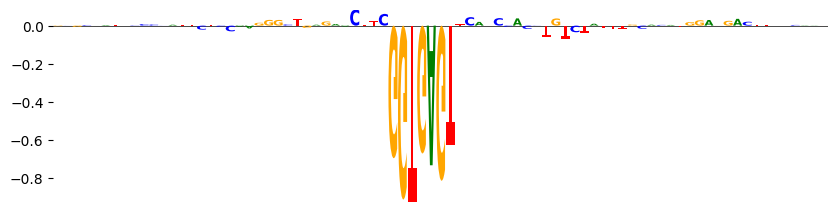

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logomaker
#
the_logo = logomaker.Logo(sal_df)
the_logo.style_spines(visible=False)
the_logo.ax.set_xticks([])

In [ ]:
plot_saliency(sal_df, negative=negative, start=0, end=90)

In [ ]:
plot_saliency(sal_df, negative=negative, start=200, end=181)

In [ ]:
# run extreme evolution:
exclude_elements = elements_to_replace
evo_df = extreme_evolve(seq, target='export', decreasing=True, exclude=exclude_elements)

In [ ]:
evo_df

In [ ]:
evo_df.iloc[0]['seq']

In [ ]:
# nucleotide interactions:
arr = connections_array(seq, target='export') # 'expression'/'export'

In [ ]:
arr

In [ ]:
plot_connections(arr, size=9)